In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors
from glob import glob
from tqdm import tqdm

## Plot Config

In [146]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
    "acsincome" : "ACSIncome",
    "taiwan" : "Taiwan Credit",
    "enem" : "ENEM"
}
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "LGBMRegressor" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "FairGBMClassifier_eod" : "#fc8d62",
    "MinMaxFair" : "#a6d854",
    "MinMaxFairRegressor" : "#a6d854",
    "MinMaxFair_tpr" : "#a6d854",
    "MinMaxFairRegressor" : "#a6d854",
    "M2FGBClassifier" : "#8da0cb",
    "M2FGBClassifier_v1" : "#8da0cb",
    "M2FGBClassifier_tpr" : "#8da0cb",
    "M2FGBClassifier_pr" : "#8da0cb",
    "M2FGBRegressor" : "#8da0cb",
    "MinimaxPareto" : "pink",
    "MinimaxPareto_tpr" : "pink"
}
methods_names = {
    "LGBMClassifier" : "LGBM",
    "LGBMRegressor" : "LGBM",
    "FairGBMClassifier" : "FairGBM",
    "FairGBMClassifier_eod" : "FairGBM (eod)",
    "M2FGBClassifier_tpr" : "M²FGB (tpr)",
    "M2FGBClassifier_pr" : "M²FGB (pr)",
    "M2FGBClassifier" : "M²FGB",
    "M2FGBRegressor" : "M²FGB",
    "MinMaxFair" : "MinMaxFair",
    "MinMaxFair_tpr" : "MinMaxFair (tpr)",
    "MinimaxPareto" : "MMPF",
    "MinimaxPareto_tpr" : "MMPF (tpr)",
    "MinMaxFairRegressor" : "MinMaxFair",
}

handles = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" not in key and "pr" not in key and "eod" not in key
]

handles_tpr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" in key or "LGBMClassifier" in key or "eod" in key
]
handles_pr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "_pr" in key or "LGBM" in key
]

## Functions

In [3]:
SEED = 0

## Convergence Plots

In [149]:
import sys
sys.path.append("../scripts")
import data
import models
import utils

In [150]:
args = {
    "dataset" : "german",
    "n_groups" : 4,
}
X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test = (
    data.get_strat_split(args["dataset"], args["n_groups"], 20, SEED)
)

{'Male,Older 30': 0, 'Female,Under 30': 1, 'Male,Under 30': 2, 'Female,Older 30': 3}


In [353]:
params = {
    "learning_rate" : 0.1,
    "max_depth" : 4,
    "min_child_weight" : 0.005,
    "reg_lambda" : 1000
}

In [354]:
def call_model(iter, method):
    if method == "m2fgb":
        return models.M2FGBClassifier(
            multiplier_learning_rate=0.3,
            fair_weight=1,
            n_estimators=iter,
            dual_learning="gradient_norm",
            random_state=SEED,
            **params
        )
    elif method == "lgbm":
        return models.LGBMClassifier(
            n_estimators=iter,
            random_state=SEED,
            **params
        )


iters_list = list(range(5, 100, 5))
methods_names = ["m2fgb", "lgbm"]
score = {}
score["train"] = dict([(m, []) for m in methods_names])
score["test"] = dict([(m, []) for m in methods_names])
computing_time = dict([(m, 0) for m in methods_names])

for method in methods_names:
    for iter in tqdm(iters_list):
        model = call_model(iter, method)
        #start = time()
        model.fit(X_train, Y_train, A_train)
        #end = time()

        #computing_time[method] = end - start

        Y_pred = model.predict_proba(X_train)[:, 1]
        score["train"][method].append(utils.logloss_group(Y_train, Y_pred, A_train, "equalized_loss"))
        
        Y_pred = model.predict_proba(X_test)[:, 1]
        score["test"][method].append(utils.logloss_group(Y_test, Y_pred, A_test, "equalized_loss"))

    score["train"][method] = np.array(score["train"][method])
    score["test"][method] = np.array(score["test"][method])


  0%|                                                                                                             | 0/19 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 49.15it/s]


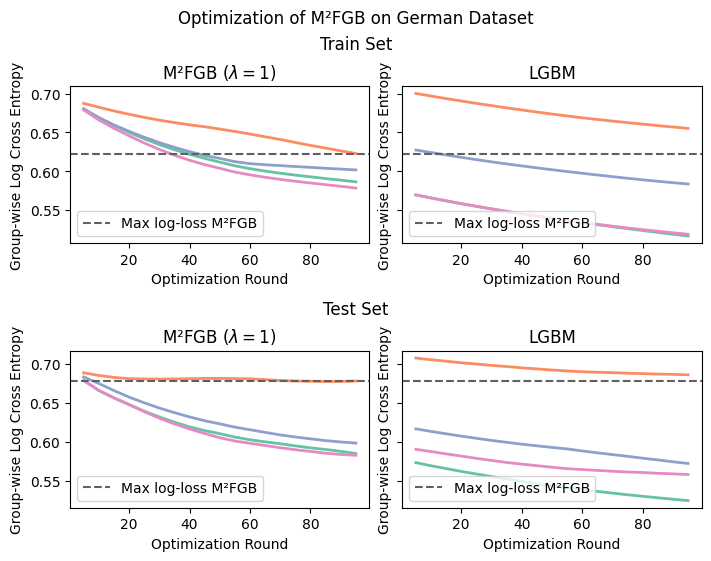

In [355]:
fig = plt.figure(constrained_layout=True, figsize = (7, 5.5))
fig.suptitle('Optimization of M²FGB on German Dataset')

subfigs = fig.subfigures(nrows=2, ncols=1)
sets = ["train", "test"]
set_names = ["Train Set", "Test Set"]
better_methods_names = {
    "lgbm" : "LGBM",
    "m2fgb" : "M²FGB ($\lambda = 1$)"
}
for row, subfig in enumerate(subfigs):
    subfig.suptitle(set_names[row])

    max_score = np.max(score[sets[row]]["m2fgb"][-1, :])
    axs = subfig.subplots(nrows=1, ncols=2, sharey=True)


    for col, ax in enumerate(axs):
        method = methods_names[col]

        ax.set_title(better_methods_names[method])

        # set color cycle to Pastel2
        ax.set_prop_cycle(color=plt.cm.Set2.colors)
        
        for ng in range(args["n_groups"]):
            ax.plot(iters_list, score[sets[row]][method][:, ng], lw = 2)


        ax.set_xlabel("Optimization Round")
        ax.set_ylabel("Group-wise Log Cross Entropy")

        ax.axhline(max_score, color = "#606060", linestyle = "--", label = "Max log-loss M²FGB")
        ax.legend(loc = "lower left")
        #ax.grid(True)

plt.savefig("../figs/convergence_german.pdf", dpi = 300)
plt.show()

## $\lambda$ parameter

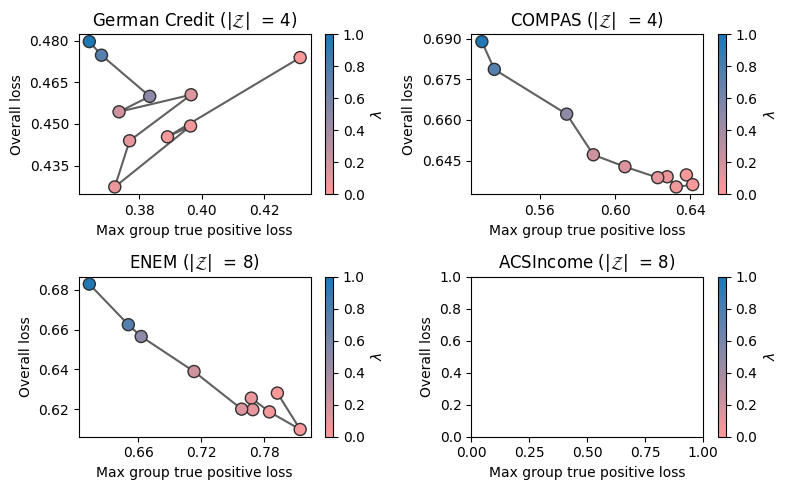

In [ ]:
norm=matplotlib.colors.Normalize(0, 1)
#norm=matplotlib.colors.Normalize(0,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#fb9a99","#1f78b4"])

fig, axs = plt.subplots(nrows =2, ncols = 2, figsize = (8, 5))
axs = axs.flatten()

for i, dataset in enumerate(["german_4", "compas_4", "enem_8", "acsincome_8"]):
    n_groups = int(dataset.split("_")[1])
    

    try:
        results = pd.read_csv(f"../results_aaai/experiment_new/fair_weight/{dataset}g/M2FGBClassifier_tpr/train.csv")
        trials = pd.read_csv(f"../results_aaai/experiment_new/fair_weight/{dataset}g/M2FGBClassifier_tpr/trials.csv")
        results = results.merge(trials)

        results["fair_weight"] = results.params_fair_weight
        results = results.loc[:, results.dtypes == "float"].groupby("fair_weight").mean().reset_index()

        
        
        
        cm = axs[i].scatter(
            results.max_logloss_tpr,
            results.logloss,
            c = results.fair_weight,
            cmap = cmap,
            norm = norm,
            zorder = 100,
            s = 75,
            ec = "#303030",
        )

        axs[i].plot(
            results.max_logloss_tpr,
            results.logloss,
            c = "#606060",
        )

    except:
        pass 

    dataset = dataset.split("_")[0]

    axs[i].set_xlabel("Max group true positive loss")
    axs[i].set_ylabel("Overall loss")

    axs[i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")

    # make x and y axis only have 4 ticks each
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    # add colorbar
    fig.colorbar(cm, ax=axs[i], label="$\lambda$")

plt.tight_layout()

plt.savefig("../figs/fair_weight.pdf", dpi = 300)
plt.show()




## new version

In [4]:
def summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    experiment_folder = "../results_aaai/experiment_new",
    n_sampled = 100,
    n_repetitions = 1000,
    version = "v1",
    aux_fair_metric = None
):

    alpha_list = [i/20 for i in range(21)]
    df_results = []
    for dataset in dataset_list:
        for model in method_list:
            try:
                #results_train = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/train.csv")
                results_val = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/val.csv")
                results_test = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/test.csv")

                print(f"Total models for {model}, {dataset} : {len(results_val)}")
                #trial = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/trials.csv")
                #for col in [col for col in trial.columns if "params_" in col]:
                #    results_test[col] = trial[col]
                #results_train["duration"] = pd.to_timedelta(results_train["duration"]).dt.total_seconds()
                results_val["duration"] = pd.to_timedelta(results_val["duration"]).dt.total_seconds()
                results_test["duration"] = pd.to_timedelta(results_test["duration"]).dt.total_seconds()

                if version == "v2":
                    metrics_col = [col for col in results_val.columns if aux_fair_metric in col]
                    # weight metrics by the inverse of the ratio of the group size
                    for col in metrics_col:
                        digit = int(col.split("=")[-1])
                        results_val[col] = results_val[col] * results_val[f"ratio_g={digit}"]
                        results_test[col] = results_test[col] * results_test[f"ratio_g={digit}"]

                    results_val[aux_fair_metric] = results_val[metrics_col].mean(axis = 1)
                    results_test[aux_fair_metric] = results_test[metrics_col].mean(axis = 1)
                    evaluated_fair_metric = aux_fair_metric
                else:
                    evaluated_fair_metric = fair_metric


                for alpha in tqdm(alpha_list):
                    for _ in range(n_repetitions):
                        # sample models
                        results_val_sample = results_val.sample(min(n_sampled, results_val.shape[0]), replace=False)
                        # compute score
                        score = alpha * results_val_sample[evaluated_fair_metric] + (1 - alpha) * results_val_sample[perf_metric]
                        # get test result of the best model in validation

                        if version == "v3":
                            top_5_scores_idx = score.nlargest(5).index
                            # random choice one
                            best_model = results_test.loc[np.random.choice(top_5_scores_idx)]
                        else:
                            best_model = results_test.loc[score.idxmax()]
                        #best_model = results_val.loc[score.idxmax()]


                        df_results.append({
                            "dataset" : dataset,
                            "model" : model,
                            "alpha" : alpha,
                            "eval_fair_metric" : best_model[evaluated_fair_metric],
                            perf_metric : best_model[perf_metric],
                            fair_metric : best_model[fair_metric],
                            "duration" : best_model.duration,
                        })
            except:
                print(f"Error in {model}, {dataset}")
    df_results = pd.DataFrame(df_results)
    #df_results_std = df_results.groupby(["dataset", "model", "alpha"]).std().reset_index()
    df_results = df_results.groupby(["dataset", "model", "alpha"]).mean().reset_index()
    return df_results

In [6]:
def plot_results(axs, df_results, perf_metric, fair_metric):
    model_list = df_results.model.unique()
    for i, model in enumerate(model_list):
        df_results_filter = df_results[df_results.model == model]
        #df_results_filter_std = df_results_std[df_results_std.model == model]

        axs[0].plot(
            df_results_filter.alpha,
            df_results_filter[perf_metric],
            c = methods_color[model],
        )
        axs[0].set_ylabel(perf_metric)
        axs[0].set_xlabel("alpha")

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[perf_metric] - 1.96 * df_results_filter_std[perf_metric],
        #     df_results_filter[perf_metric] + 1.96 * df_results_filter_std[perf_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )

        

        axs[1].plot(
            df_results_filter.alpha,
            df_results_filter[fair_metric],
            linestyle = "--",
            c = methods_color[model],
        )
        axs[1].set_ylabel(fair_metric)
        axs[1].set_xlabel("alpha")

        

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[fair_metric] - 1.96 * df_results_filter_std[fair_metric],
        #     df_results_filter[fair_metric] + 1.96 * df_results_filter_std[fair_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )   
        axs[2].plot(
            df_results_filter[perf_metric],
            df_results_filter[fair_metric],
            c = methods_color[model],
            label = model,
            #s = 25,
            marker = "o",
            linestyle = "",
        )
        axs[2].set_xlabel(perf_metric)
        axs[2].set_ylabel(fair_metric)

### min bal acc

In [40]:
perf_metric = "bal_acc"
fair_metric = "min_bal_acc"
aux_fair_metric = "acc_g"
dataset_list = ["compas_6g", "enem_6g"] #, "enem_large_27g"]
method_list = ["M2FGBClassifier", "LGBMClassifier", "FairGBMClassifier", "MinimaxPareto", "MinMaxFair"]
method_list = ["M2FGBClassifier", "LGBMClassifier"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    n_sampled=100,
    aux_fair_metric = aux_fair_metric,
    version = "v1"
)

Total models for M2FGBClassifier, compas_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.35it/s]


Total models for LGBMClassifier, compas_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.33it/s]


Total models for M2FGBClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.35it/s]


Total models for LGBMClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.35it/s]


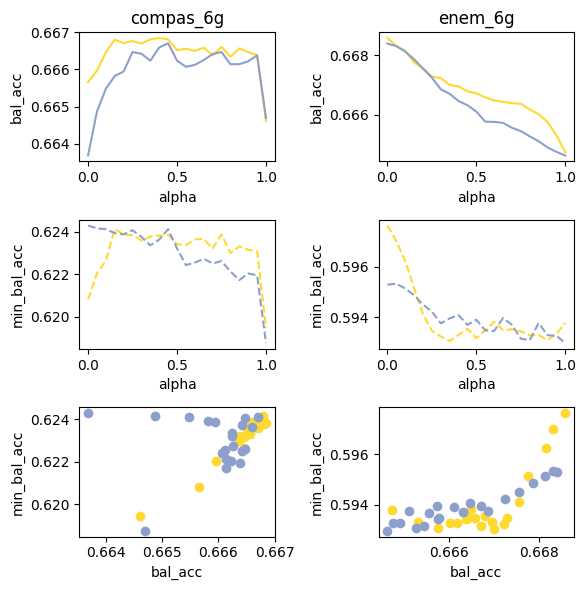

In [41]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)

plt.tight_layout()

### min acc

In [77]:
perf_metric = "acc"
fair_metric = "min_acc"
aux_fair_metric = "acc_g"
dataset_list = ["compas_6g", "enem_6g"] #, "enem_large_27g"]
method_list = ["M2FGBClassifier", "LGBMClassifier", "FairGBMClassifier", "MinimaxPareto", "MinMaxFair"]
method_list = ["M2FGBClassifier", "LGBMClassifier"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    n_sampled=100,
    aux_fair_metric = aux_fair_metric,
    version = "v3"
)

Total models for M2FGBClassifier, compas_6g : 1000


  0%|                                                                                                             | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


Total models for LGBMClassifier, compas_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


Total models for M2FGBClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


Total models for LGBMClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


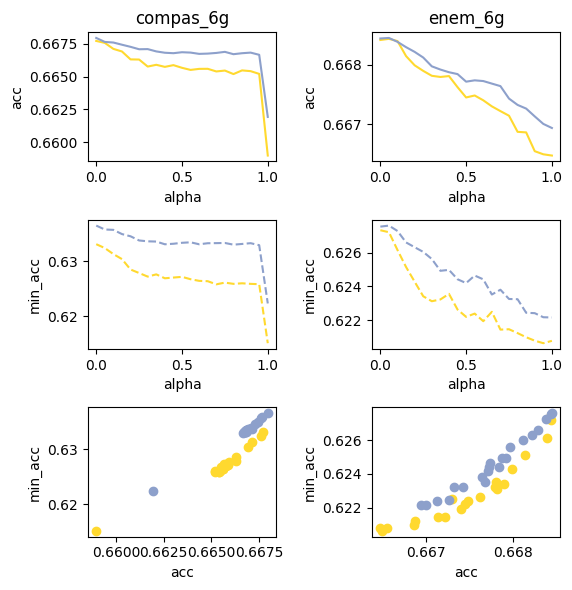

In [71]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)

plt.tight_layout()

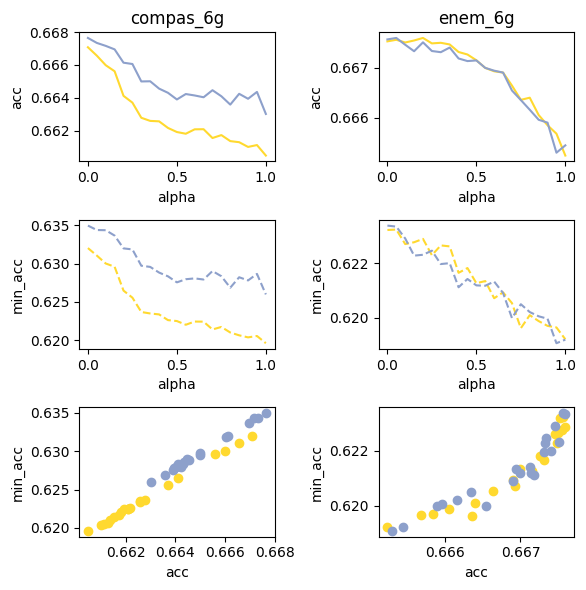

In [78]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)

plt.tight_layout()

### tpr

In [144]:
perf_metric = "bal_acc"
fair_metric = "min_tpr"
dataset_list = ["german_4g", "compas_4g", "enem_8g"] #, "enem_large_27g"]
method_list = ["M2FGBClassifier_tpr", "MinimaxPareto_tpr", "MinMaxFair_tpr", "FairGBMClassifier_eod", "LGBMClassifier"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
)

Total models for M2FGBClassifier_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:31<00:00,  1.50s/it]


Total models for MinimaxPareto_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:31<00:00,  1.52s/it]


Total models for M2FGBClassifier_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:33<00:00,  1.60s/it]


Total models for MinimaxPareto_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.40s/it]


Total models for M2FGBClassifier_tpr, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.40s/it]


Error in MinimaxPareto_tpr, enem_8g


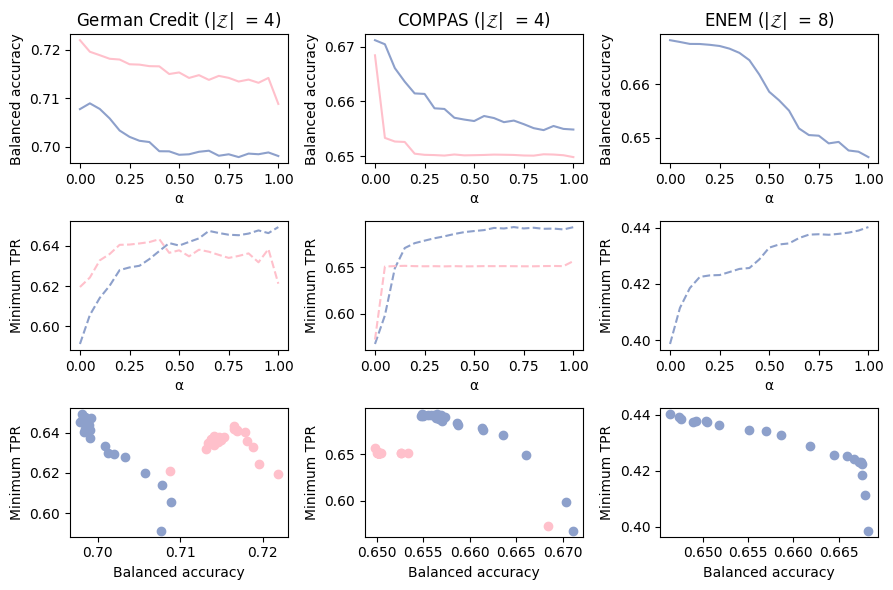

In [147]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(3):
        axs[j, i].set_xlabel("α")
    axs[0, i].set_ylabel("Balanced accuracy")
    axs[1, i].set_ylabel("Minimum TPR")

    axs[2, i].set_xlabel("Balanced accuracy")
    axs[2, i].set_ylabel("Minimum TPR")
plt.tight_layout()

(0.0, 1.0, 0.0, 1.0)

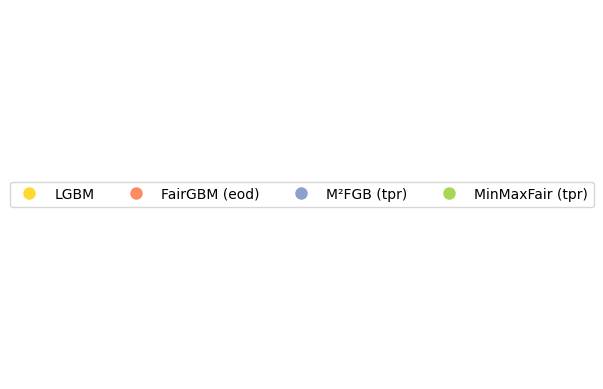

In [41]:
# plot the legend separately
fig, ax = plt.subplots()
ax.legend(handles = handles_tpr, loc = "center", ncol = len(handles_tpr), fontsize = 10)
ax.axis("off")

### mse

In [100]:
perf_metric = "mse"
fair_metric = "max_mse"
experiment_folder = "../results_aaai/experiment_new" 
alpha_list = [i/20 for i in range(21)]
df_results = []
dataset_list = ["enem_reg_8g"]
method_list = ["M2FGBRegressor", "LGBMRegressor"] #, "MinMaxFairRegressor"]
n_sampled = 100
n_repetitions = 1000
for dataset in dataset_list:
    for model in method_list:
        results_train = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/train.csv")
        results_val = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/val.csv")
        results_test = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/test.csv")

        print(f"Total models for {model}, {dataset} : {len(results_val)}")
        trial = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/trials.csv")
        for col in [col for col in trial.columns if "params_" in col]:
            results_test[col] = trial[col]
        results_train["duration"] = pd.to_timedelta(results_train["duration"]).dt.total_seconds()
        results_val["duration"] = pd.to_timedelta(results_val["duration"]).dt.total_seconds()
        results_test["duration"] = pd.to_timedelta(results_test["duration"]).dt.total_seconds()

        for alpha in tqdm(alpha_list):
            for _ in range(n_repetitions):
                results_val_sample = results_val.sample(min(n_sampled, results_val.shape[0]), replace=False)
                score = alpha * -results_val_sample[fair_metric] + (1 - alpha) * -results_val_sample[perf_metric]
                best_model = results_test.loc[score.idxmax()]


                df_results.append({
                    "dataset" : dataset,
                    "model" : model,
                    "alpha" : alpha,
                    perf_metric : best_model[perf_metric],
                    fair_metric : best_model[fair_metric],
                    "duration" : best_model.duration,
                })

df_results = pd.DataFrame(df_results)
df_results_std = df_results.groupby(["dataset", "model", "alpha"]).std().reset_index()
df_results = df_results.groupby(["dataset", "model", "alpha"]).mean().reset_index()

Total models for M2FGBRegressor, enem_reg_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.22it/s]


Total models for LGBMRegressor, enem_reg_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


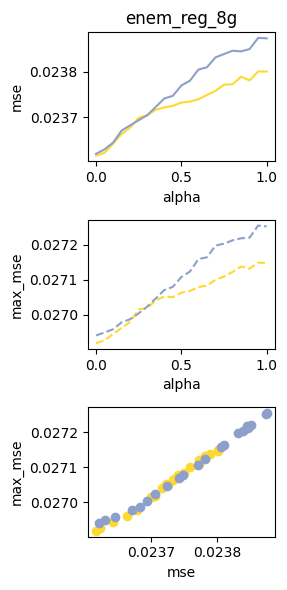

In [101]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

def plot_results(axs, df_results):
    model_list = df_results.model.unique()
    for i, model in enumerate(model_list):
    #for i, model in enumerate(["M2FGBRegressor", "LGBMRegressor"]):
        df_results_filter = df_results[df_results.model == model]
        #df_results_filter_std = df_results_std[df_results_std.model == model]

        axs[0].plot(
            df_results_filter.alpha,
            df_results_filter[perf_metric],
            c = methods_color[model],
        )
        axs[0].set_ylabel(perf_metric)
        axs[0].set_xlabel("alpha")

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[perf_metric] - 1.96 * df_results_filter_std[perf_metric],
        #     df_results_filter[perf_metric] + 1.96 * df_results_filter_std[perf_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )

        

        axs[1].plot(
            df_results_filter.alpha,
            df_results_filter[fair_metric],
            linestyle = "--",
            c = methods_color[model],
        )
        axs[1].set_ylabel(fair_metric)
        axs[1].set_xlabel("alpha")
        

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[fair_metric] - 1.96 * df_results_filter_std[fair_metric],
        #     df_results_filter[fair_metric] + 1.96 * df_results_filter_std[fair_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )   
        axs[2].plot(
            df_results_filter[perf_metric],
            df_results_filter[fair_metric],
            c = methods_color[model],
            label = model,
            #s = 25,
            marker = "o",
            linestyle = "",
        )
        axs[2].set_xlabel(perf_metric)
        axs[2].set_ylabel(fair_metric)


for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)


plt.tight_layout()

## testing bugs

In [46]:
import sys
sys.path.append("../scripts")
import data
import models

%load_ext autoreload
%autoreload 2

In [47]:
args = {
    "dataset" : "enem",
    "n_groups" : 8,
}
X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test = (
    data.get_strat_split(args["dataset"], args["n_groups"], 20, SEED)
)

{'Brown, Male': 0, 'Black, Female': 1, 'White, Female': 2, 'Other, Female': 3, 'Brown, Female': 4, 'Black, Male': 5, 'White, Male': 6, 'Other, Male': 7}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [82]:
m = models.MinMaxFair(n_estimators=3)
m.fit(X_train, Y_train, A_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/work/giovani.valdrighi/dual_fair_boost/notebooks/../minimax-fair/src/minmaxML.py:510: UserWarning: WARNING: Desired gamma value may not be feasible with margin of error: 0.001. 
Gamma = 0.5510281805736663 but the mixture's max groups error was [0.6746104889911865]
  warnings.warn(f'WARNING: Desired gamma value may not be feasible with margin of error: '


MinMaxFair(n_estimators=3)

In [83]:
X_val.shape

(9996, 168)

In [78]:
X_val.shape

(9996, 168)

In [101]:
pred = m.predict_proba(X_val)

In [99]:
Y_val

15152    1
41344    0
43969    0
37730    1
4139     0
        ..
23132    0
44501    1
31386    0
717      0
10582    0
Name: gradebin, Length: 9996, dtype: int64

In [89]:
pred = np.stack(pred)

In [90]:
pred.shape

(3, 9996)

In [91]:
idx = np.random.choice(pred.shape[0], pred.shape[1], replace = True).reshape(1, -1)
idx.shape

(1, 9996)

In [94]:
pred = np.take_along_axis(pred, idx, axis = 0)
pred = np.stack([pred, 1 - pred], axis = -1)
pred.shape

(1, 9996, 2)

In [95]:
pred

array([[[0.42614467, 0.57385533],
        [0.47821795, 0.52178205],
        [0.41347218, 0.58652782],
        ...,
        [0.43789353, 0.56210647],
        [0.42177156, 0.57822844],
        [0.44429907, 0.55570093]]])

In [ ]:
tenho 3 valores e 4 linhas
para cada linha quero sortear um valor

In [67]:
a.shape

(3, 4)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [68]:
idx

array([[0, 2, 1, 2]])

In [71]:
a = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
])



print(a.shape, idx.shape)
np.take_along_axis(a, idx, axis = 0)

(3, 4) (1, 4)


array([[ 1,  6,  7, 12]])

In [72]:
a

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [34]:
a

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [ ]:
def select_one_per_row(a):
    m,n = a.shape
    idx1 = np.random.randint(0,n,m)
    out = np.take_along_axis(a, np.c_[idx1, idx1 - idx2], axis=1)
    return out

In [25]:
np.random.randint(0, 5, 100)

array([0, 4, 2, 3, 2, 1, 2, 1, 2, 0, 4, 4, 1, 3, 3, 4, 0, 2, 3, 0, 3, 1,
       2, 4, 1, 3, 1, 2, 4, 1, 0, 3, 3, 2, 1, 3, 1, 4, 2, 3, 2, 2, 0, 3,
       3, 4, 3, 4, 1, 1, 2, 3, 1, 0, 1, 1, 3, 1, 3, 0, 1, 1, 3, 3, 3, 1,
       3, 0, 1, 2, 1, 3, 2, 1, 1, 2, 0, 1, 0, 4, 4, 2, 1, 0, 3, 3, 3, 0,
       1, 2, 0, 1, 3, 2, 4, 2, 0, 3, 1, 3])

In [24]:
idx

array([0, 1, 0, 0, 2, 2, 2, 0, 1, 0, 2, 1, 4, 4, 4, 4, 4, 4, 3, 0, 2, 4,
       3, 3, 2, 1, 3, 3, 3, 4, 4, 3, 3, 2, 0, 1, 4, 4, 3, 3, 4, 0, 4, 1,
       4, 2, 2, 1, 3, 3, 3, 0, 2, 0, 0, 0, 2, 0, 0, 1, 2, 1, 4, 3, 1, 4,
       3, 4, 4, 2, 4, 1, 4, 3, 4, 4, 3, 0, 4, 4, 4, 0, 2, 4, 1, 3, 3, 2,
       2, 3, 1, 2, 2, 1, 2, 2, 0, 4, 4, 0])

(5, 100)

In [13]:
idx

array([4, 0, 4, 1, 1, 1, 3, 4, 3, 4, 2, 4, 2, 3, 2, 2, 0, 1, 4, 2, 1, 0,
       1, 2, 2, 2, 1, 0, 0, 4, 0, 2, 1, 4, 4, 3, 0, 2, 4, 2, 2, 0, 0, 1,
       1, 3, 1, 1, 4, 2, 0, 2, 0, 3, 1, 3, 4, 2, 1, 2, 1, 0, 2, 1, 3, 2,
       3, 1, 4, 2, 2, 1, 4, 0, 2, 3, 1, 3, 3, 4, 0, 2, 4, 1, 1, 1, 3, 3,
       1, 4, 2, 3, 2, 4, 1, 0, 2, 3, 4, 2])